In [1]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

In [2]:
%cd ..

/home/stefan/projects/theanogeometry


# PPCA aon $\mathbb{S}^2$

In [3]:
from src.manifolds.S2 import *
M = S2()
print(M)

from src.plotting import *

2d sphere (ellipsoid parameters [ 1.  1.  1.])


In [4]:
%matplotlib notebook

In [5]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

# element, tangent vector and covector
x = np.array([0.,0.])
v = np.array([.75,-.75])
p = M.flatf(x,v)

print("x = ", x)
print("v = ", v)
print("p = ", p)

x =  [ 0.  0.]
v =  [ 0.75 -0.75]
p =  [ 3. -3.]


<IPython.core.display.Javascript object>


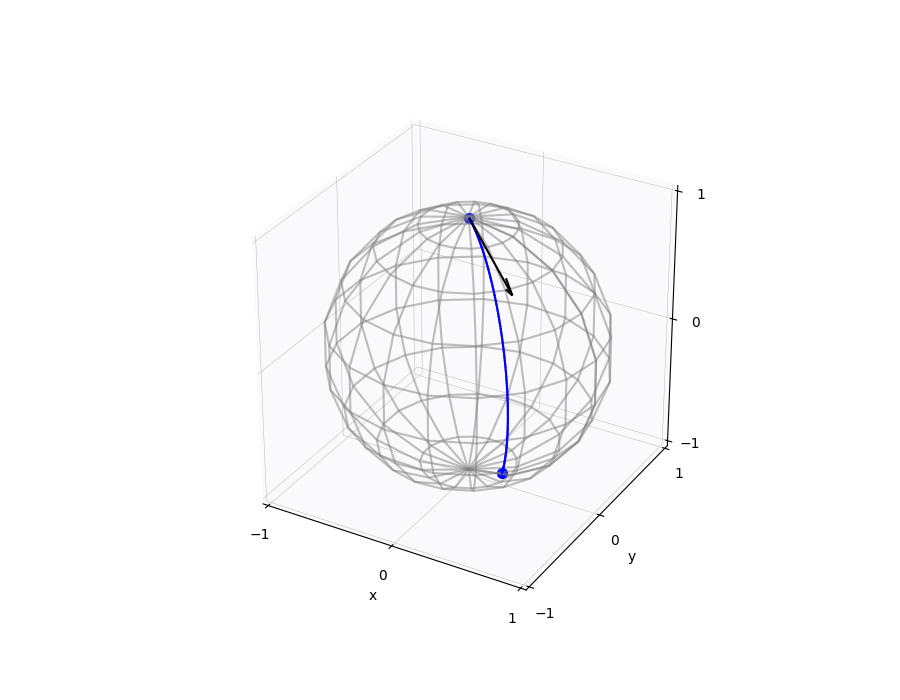

In [6]:
# 2nd order geodesic equation
from src.Riemannian import geodesic
geodesic.initialize(M)

xs = M.Exptf(x,v)

newfig()
M.plot()
M.plotx(xs,v,linewidth = 1.5, s=50)
plt.show()

v = xs[-1]

## Brownian Motion

<IPython.core.display.Javascript object>


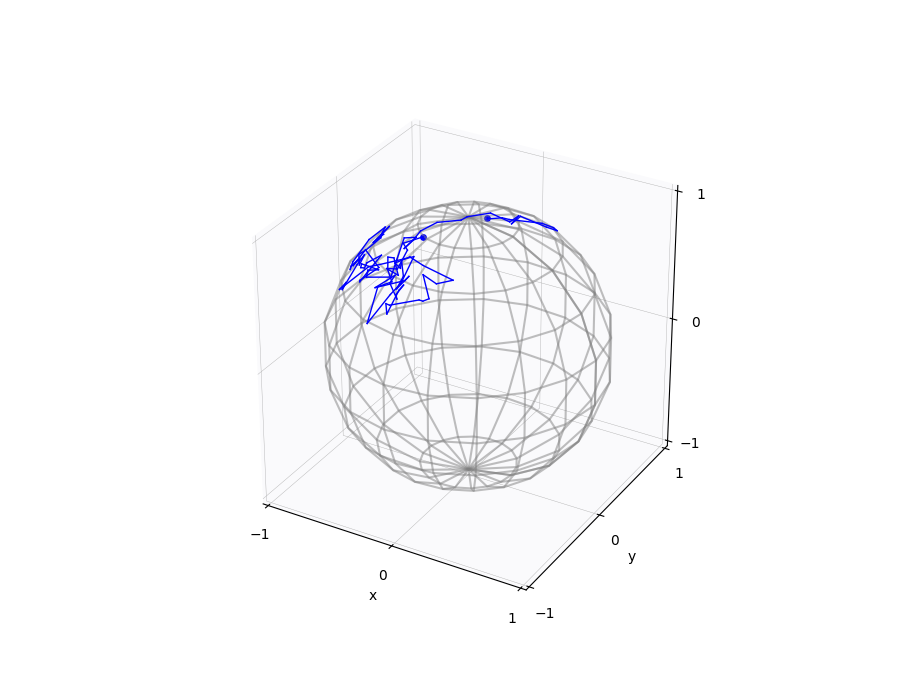

In [7]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

(ts,xs) = M.Brownian_coordsf(x,dWsf(M.dim.eval()))
newfig()
M.plot()
M.plotx(xs)
plt.show()

log likelihood:  0.332334514818 , log varphi:  0.0316509219803


<IPython.core.display.Javascript object>


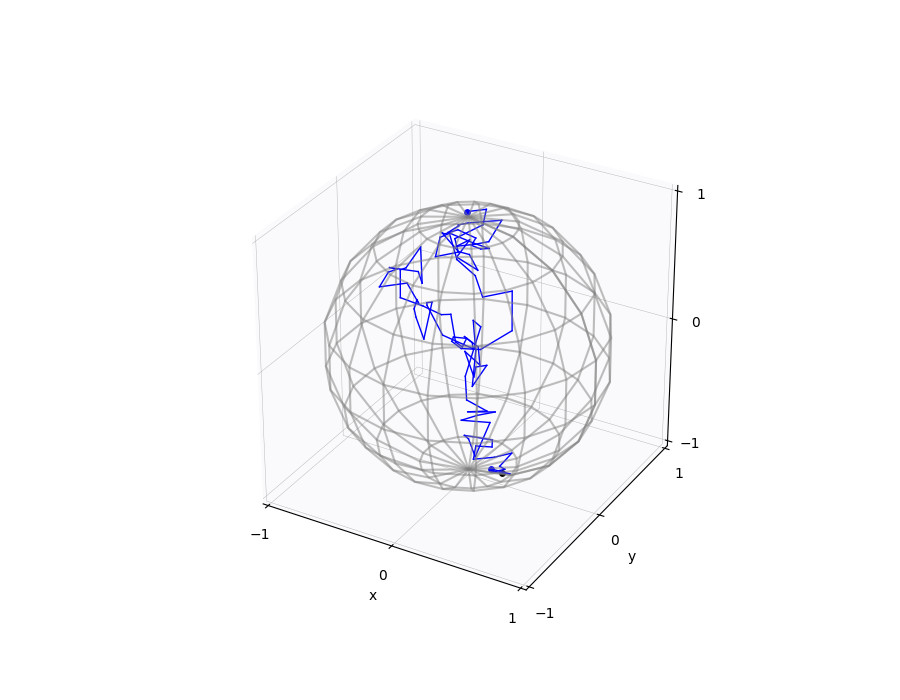

In [8]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

# guide function
phi = lambda g,v: -(g-v)
x0 = M.element()
(dlog_likelihood,dlog_likelihoodf,Brownian_coords_guided,Brownian_coords_guidedf) = get_guided_likelihood(M,M.sde_Brownian_coords,phi,lambda x: theano.tensor.slinalg.Cholesky()(M.gsharp(x)), x0, ())

(ts,xs,log_likelihood,log_varphi) = Brownian_coords_guidedf(x,v,dWsf(M.dim.eval()))[:4]
print("log likelihood: ", log_likelihood[-1], ", log varphi: ", log_varphi[-1])

newfig()
M.plot()
M.plotx(xs)
M.plotx(v,color='k')
plt.show()

In [9]:
# Hamiltonian MCMC
# adapted from http://www.mcmchandbook.net/HandbookChapter5.pdf

def HMC_step(U, grad_U, epsilon, L, current_q):
    q = np.copy(current_q)
    p = dWsf(M.dim.eval()) # independent standard normal variates
    current_p = np.copy(p)

    # Make a half step for momentum at the beginning
    p += -epsilon * grad_U(q) / 2
    # Alternate full steps for position and momentum
    for i in range(L):
        # Make a full step for the position
        q += epsilon * p
        
        # Make a full step for the momentum, except at end of trajectory
        if i != L:
            p += -epsilon * grad_U(q)

    # Make a half step for momentum at the end.
    p += -epsilon * grad_U(q) / 2
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p**2) / 2

    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    density = np.exp(current_U-proposed_U+current_K-proposed_K)
#     print(np.log(density))
#     print(current_U)
#     print(proposed_U)
#     print(current_K)    
#     print(proposed_K)
    
    if (np.random.uniform() < density):
        print('accept', density)
        return (q) # accept
    else:
        print('reject', density)        
        return (current_q) # reject

def Uf(w):
    (_,_,log_likelihood,log_varphi) = Brownian_coords_guidedf(x,v,w)[:4]
    return log_likelihood[-1]*log_varphi[-1]
def get_dUf():
    ve = M.element()
    (_,_,log_likelihood,log_varphi) = Brownian_coords_guided(x0,ve,dWt)[:4]
    dUf = theano.function([x0, ve, dWt], T.grad(log_likelihood[-1]*log_varphi[-1],dWt))
    return lambda w: dUf(x,v,w)
dUf = get_dUf()

accept 0.996145147709
accept 0.995560841073
accept 0.997901678026
reject 0.994841917884
accept 0.994421991736
accept 0.994979214553
accept 0.996065575381
accept 0.998164516137
accept 0.997565127157
accept 0.999880286978


<IPython.core.display.Javascript object>


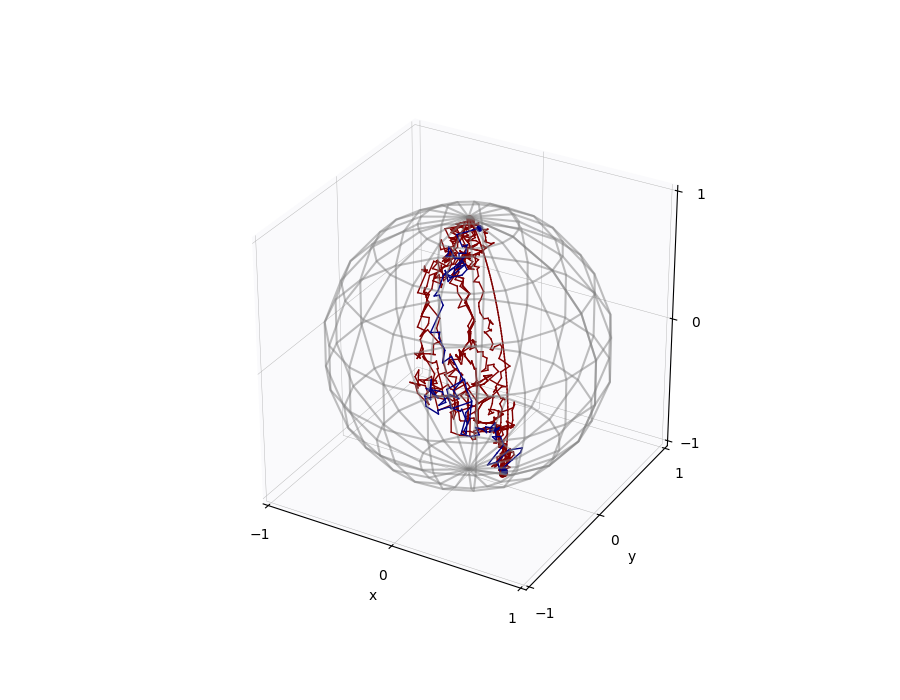

<IPython.core.display.Javascript object>


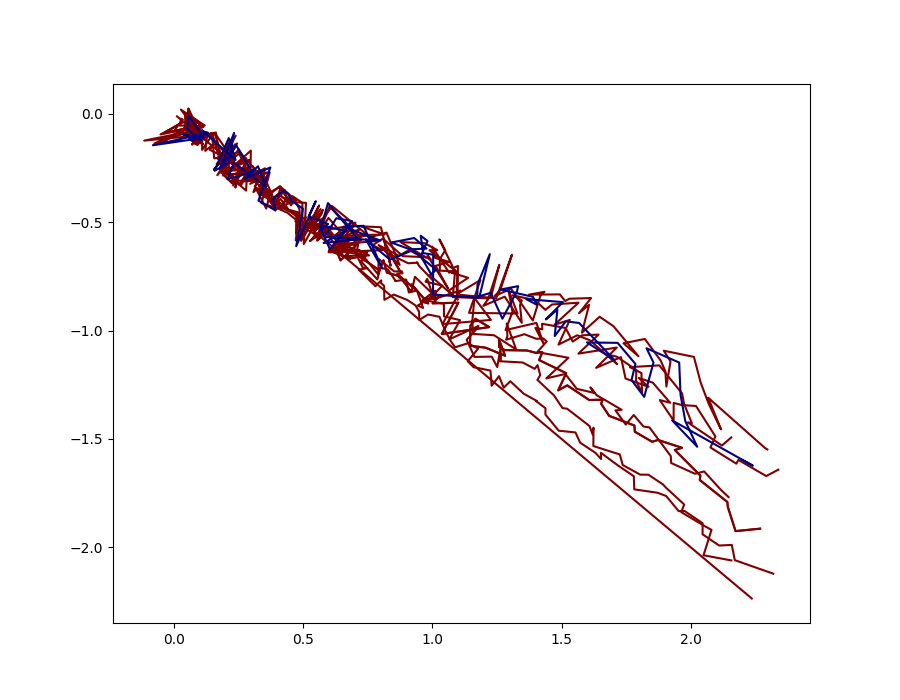

In [10]:
# run HMC
w = 0*dWsf(M.dim.eval())
K = 10
L = 4
epsilon = .2/L
ws = np.zeros((K,) + w.shape)
xss = np.zeros((K,) + xs.shape)
vals = np.zeros(K)
for k in range(K):
    (ts,xs,log_likelihood,log_varphi,h) = Brownian_coords_guidedf(x,v,w)[:5]
    ws[k] = w+h
    xss[k] = xs
    vals[k] = log_likelihood[-1]*log_varphi[-1]
    
    w = HMC_step(Uf, dUf, epsilon, L, w)

# colors
cmap = cm.jet
cs = cmap(255*(vals-np.min(vals))/(np.max(vals)-np.min(vals)))

# plot result
newfig()
M.plot()
M.plotx(v,color='k')
for k in range(K):
    M.plotx(xss[k],color=cs[k])
plt.show()

# noise
plt.figure()
for k in range(K):
    plt.plot(ws[k][:,0],ws[k][:,1],color=cs[k])
plt.show()